In [1]:
# Import pytorch et CIFRAR dataset
import torch
from torchvision import datasets
from torch import nn, optim
import numpy as np
from torch.utils.data import Dataset, DataLoader # DataLoader est util pour former des minibatchs
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import skimage

In [2]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)

100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


[[101  95  97 ...  56  55  55]
 [ 68  66  65 ...  71  93  61]
 [ 75  60  52 ...  80 105  71]
 ...
 [ 70  65  65 ...  15  26  36]
 [ 74  72  70 ...  14  22  27]
 [ 82  78  77 ...  14  17  19]]


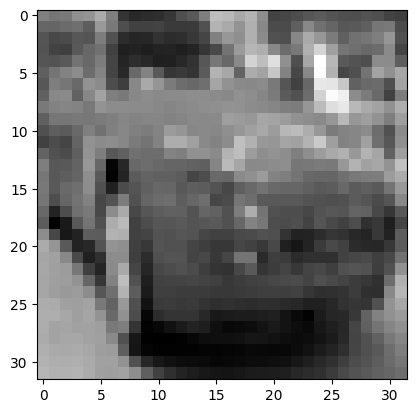

In [3]:
#print(train_dataset.targets[0]) # to access CIFRAR image do train_dataset[i][0] and target => train_dataset.targets[i] ou train_dataset[i][1]
# Now colored images become targets
#print(train_dataset.targets)
#print(np.array(train_dataset[0][0]).shape)
image_exemple = np.array(train_dataset[5][0])
#print(image_exemple)
image = skimage.color.rgb2lab(image_exemple)
#print(image.shape)
print(image_exemple[:,:,2])
plt.imshow(image[:,:,0], cmap="grey")
plt.show()

In [4]:
# Récupérer image target et créer le training set en transformant les images en nuances de gris.
# Il faut 2 versions, une pour l'affichage (sous forme de PIL images) et après normalisation *255

class CustomImageCorlorisationDataset(Dataset) :
    def __init__(self, dataSet, lab_mode=True, transform=None, target_transform=None):
        self.test_lab_value =[]
        if lab_mode== True :
          self.CreateTupleLabImage(dataSet)
        else :
          self.CreateTupleRGBImage(dataSet)

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images_tuple)

    def __getitem__(self, idx):
      image_input, image_target = self.images_tuple[idx][0], self.images_tuple[idx][1]
      image_target = np.swapaxes(np.swapaxes(image_target, 0, 2), 1, 2)
      return image_input, image_target

    def Switch_to_GreyScale(self, image):
      # 0.3 * c.r + 0.59 * c.g + 0.11 * c.b
      return np.average(image, axis=2, weights=[0.3, 0.59, 0.11])

    def toDisplay(self,index, color=True):
      # N = self.images_tuple[index][0].shape[0] # Ne marche que si les images sont rectangulaire et que le cannal RGB est la 3ème dimension, à revoir si on change de dataset
      if color :
        mode='RGB'
        numpy_image = (self.images_tuple[index][1]*255)
      else:
        mode='L' # grey scale
        numpy_image = (self.images_tuple[index][0]*255)

      return Image.fromarray(numpy_image.astype('uint8'), mode)
      # Voir si ca marche, sinon self.images_tuple[index][1] # pour le greyscale

    def CreateTupleRGBImage(self, datasetsRGB):
      self.images_tuple = []
      for rgb_image, _ in datasetsRGB :
        numpy_image_rgb = np.array(rgb_image) # rgb_image est un PIL Image
        image_input = self.Switch_to_GreyScale(numpy_image_rgb)
        self.images_tuple.append((image_input/255, numpy_image_rgb/255)) # Normalisation

    def CreateTupleLabImage(self, datasetsRGB):
      self.images_tuple = []
      for rgb_image, _ in datasetsRGB :
        numpy_image_rgb = np.array(rgb_image) # rgb_image est un PIL Image
        image_input = skimage.color.rgb2lab(numpy_image_rgb)
        self.test_lab_value.append(image_input[:,:,1:])
        self.images_tuple.append((image_input[:,:,0]/100, (image_input[:,:,1:]+107.86)/206.1)) # Normalisation




In [5]:
real_training_set = CustomImageCorlorisationDataset(train_dataset, lab_mode=False)

In [6]:
real_valid_set = CustomImageCorlorisationDataset(test_dataset, lab_mode=False)

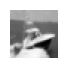

In [7]:
# Afficher quelques images du dataset

index_image = 8
color, cmap = False, "gray"
plt.imshow(real_training_set.toDisplay(index_image, color=color), cmap=cmap)
plt.subplots_adjust(left=0.4, right=0.5, top=0.5, bottom=0.4)
plt.axis('off')
plt.show()

In [8]:
data_loader_rgb = DataLoader(real_training_set, batch_size=20, shuffle=True)

In [9]:
# Architecture du modèle => comme une classification et ensuite on rajoute des layers pour les couleurs ??
# Skip connection
# Tester PSNR et SSIM
class NeuralNetwork(nn.Module):
    def __init__(self, lab_mode=True):
        super().__init__()
        self.criterion = nn.MSELoss()
        if lab_mode == True :
          nb_final_channel = 2
        else :
          nb_final_channel = 3
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=30, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(in_channels=30, out_channels= 90, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            #nn.Conv2d(in_channels=90, out_channels= 180, kernel_size=(3,3)),
            #nn.ReLU(),
            #nn.Upsample(scale_factor=2, mode='bilinear')
            nn.ConvTranspose2d(in_channels=90, out_channels=30, kernel_size=(3,3)),
            nn.ReLU(),
            nn.UpsamplingNearest2d(size =(16,16)),
            nn.ConvTranspose2d(in_channels=30, out_channels= nb_final_channel, kernel_size=(3,3)),
            nn.UpsamplingNearest2d(size =(32,32)),
            nn.Sigmoid()
            # Ici faire l'architecture inverse
        )
        self.optimizer = optim.Adam(self.parameters())

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

    def fit(self, data_loader, num_epochs=10):
      for epoch in range(num_epochs):
        self.train() # Surtout nécessaire si on fait du dropout ou de la batch normalisation
        epoch_loss = 0.0
        for inputs, targets in data_loader:
            #print(inputs.shape)
            inputs = np.reshape(inputs, [20,1,32,32])
            outputs = self.forward(inputs.float())
            #print(outputs.shape)
            #print(targets.shape)
            loss = self.criterion(outputs, targets.float())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
        print(f"Époque {epoch + 1}/{num_epochs}, Perte moyenne: {epoch_loss / len(data_loader):.4f}")

In [10]:
model_rgb = NeuralNetwork(lab_mode=False)
model_rgb.fit(data_loader_rgb)

Époque 1/10, Perte moyenne: 0.0169
Époque 2/10, Perte moyenne: 0.0143
Époque 3/10, Perte moyenne: 0.0137
Époque 4/10, Perte moyenne: 0.0133
Époque 5/10, Perte moyenne: 0.0131
Époque 6/10, Perte moyenne: 0.0130
Époque 7/10, Perte moyenne: 0.0129
Époque 8/10, Perte moyenne: 0.0128
Époque 9/10, Perte moyenne: 0.0127
Époque 10/10, Perte moyenne: 0.0127


In [11]:
def Display_images(model, data_loader, nb_image=10, lab=True):
  for inputs, targets in data_loader:
    inputs = np.reshape(inputs, [20,1,32,32])
    target = targets
    outputs = model.forward(inputs.float())
    break

  input_s = inputs.detach().numpy()
  output_s = outputs.detach().numpy()
  target_s = targets.detach().numpy()

  if lab :
    image, target, image_grey = ConvertLabToRGB(input_s, output_s, target_s)

  #images = np.swapaxes(np.swapaxes(image[0], 0, 1), 1, 2)
  plt.figure()

  for i in range(1,nb_image+1):
    target =  process_image(target_s[i])
    image = process_image(output_s[i])
    plt.subplot(3, nb_image, i)  # 1 row, 2 columns, 1st plot
    plt.imshow(target)
    plt.axis('off')
    plt.subplot(3, nb_image, i+ nb_image)  # 1 row, 2 columns, 1st plot
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(3, nb_image, i+ nb_image)  # 1 row, 2 columns, 1st plot
    plt.imshow(image)
    plt.axis('off')
  plt.show()

In [12]:
def process_image(image):
  image = np.swapaxes(np.swapaxes(image, 0, 1), 1, 2)
  return image

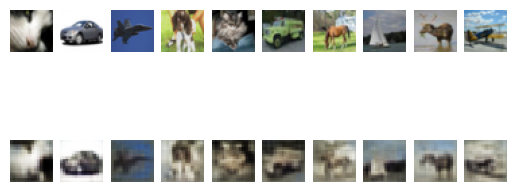

In [16]:
Display_images(model_rgb, data_loader_rgb, lab=False)

In [17]:
data_loader_valid_rgb =  DataLoader(real_valid_set, batch_size=20, shuffle=True)

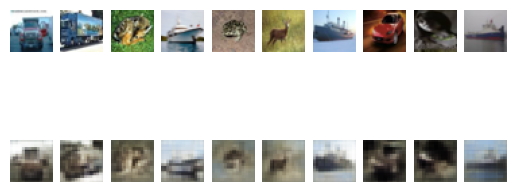

In [19]:
Display_images(model_rgb, data_loader_valid_rgb, lab=False)

In [20]:
real_training_lab = CustomImageCorlorisationDataset(train_dataset)

In [57]:
real_max_a=0
real_min_a =0
real_max_b=0
real_min_b =0

print(len( real_training_lab.test_lab_value))
for image in real_training_lab.test_lab_value :
  hist = np.histogram(image)

  #print(image.shape)
  max_a = np.max(image[:,:,0])
  min_a = np.min(image[:,:,0])
  max_b = np.max(image[:,:,1])
  min_b = np.min(image[:,:,1])
  if max_a > real_max_a :
    real_max_a = max_a
  if min_a < real_min_a:
    real_min_a = min_a
  if max_b > real_max_b :
    real_max_b = max_b
  if min_b < real_min_b:
    real_min_b = min_b
  last_image = image

print("max_a : ", real_max_a)
print("min_a : ", real_min_a)
print("max_b : ", real_max_b)
print("min_b : ", real_min_b)

50000
max_a :  98.23305386311321
min_a :  -86.18302974439501
max_b :  94.47812227647823
min_b :  -107.85730020669489


(array([[ 0.,  0., 10., 13.,  7.,  0.,  1.,  1.,  0.,  0.],
        [ 2.,  8.,  8., 10.,  2.,  0.,  2.,  0.,  0.,  0.],
        [ 4.,  5.,  9.,  5.,  6.,  1.,  2.,  0.,  0.,  0.],
        [ 2.,  3., 10., 11.,  5.,  1.,  0.,  0.,  0.,  0.],
        [ 1.,  2., 13., 11.,  5.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  2., 10., 12.,  6.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  3., 12., 11.,  4.,  0.,  0.,  0.,  0.,  0.],
        [ 3.,  3.,  6., 15.,  5.,  0.,  0.,  0.,  0.,  0.],
        [ 3.,  4.,  2., 14.,  9.,  0.,  0.,  0.,  0.,  0.],
        [ 3.,  4.,  2., 10., 11.,  2.,  0.,  0.,  0.,  0.],
        [ 3.,  3.,  4.,  9., 10.,  3.,  0.,  0.,  0.,  0.],
        [ 2.,  3.,  6.,  9., 11.,  1.,  0.,  0.,  0.,  0.],
        [ 4.,  1., 10.,  6., 11.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  9., 11., 11.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  2.,  4., 16.,  9.,  1.,  0.,  0.,  0.,  0.],
        [ 1.,  2.,  9., 10., 10.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  2.,  8., 11., 11.,  0.,  

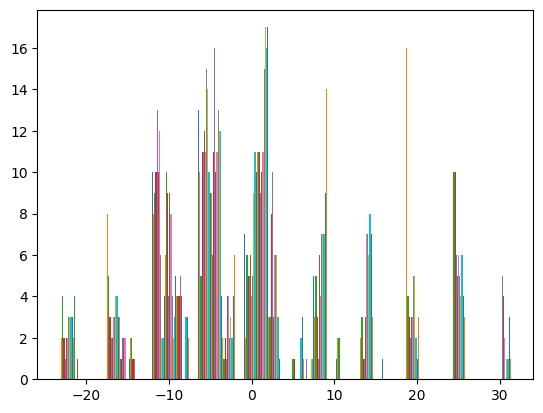

In [55]:
plt.hist(real_training_lab.test_lab_value[1][:,:,1])

In [21]:
data_loader_lab = DataLoader(real_training_lab, batch_size=20, shuffle=True)

In [22]:
for image, image_target in data_loader_lab :
  print(image_target[0])
  break

tensor([[[0.5233, 0.5216, 0.5172,  ..., 0.5162, 0.5227, 0.5233],
         [0.5233, 0.5225, 0.5173,  ..., 0.4945, 0.5134, 0.5233],
         [0.5233, 0.5225, 0.5163,  ..., 0.4785, 0.5042, 0.5225],
         ...,
         [0.5225, 0.5218, 0.5193,  ..., 0.5270, 0.5232, 0.5190],
         [0.5233, 0.5217, 0.5241,  ..., 0.5297, 0.5241, 0.5181],
         [0.5233, 0.5200, 0.5198,  ..., 0.5264, 0.5258, 0.5248]],

        [[0.5234, 0.5281, 0.5341,  ..., 0.5000, 0.5152, 0.5234],
         [0.5234, 0.5257, 0.5340,  ..., 0.5443, 0.5305, 0.5234],
         [0.5234, 0.5257, 0.5369,  ..., 0.5804, 0.5510, 0.5257],
         ...,
         [0.5257, 0.5176, 0.5193,  ..., 0.5086, 0.5286, 0.5458],
         [0.5234, 0.5228, 0.5263,  ..., 0.5014, 0.5263, 0.5484],
         [0.5234, 0.5274, 0.5330,  ..., 0.5053, 0.5216, 0.5346]]],
       dtype=torch.float64)


In [35]:
model_lab = NeuralNetwork()
model_lab.fit(data_loader_lab, num_epochs=20)

Époque 1/20, Perte moyenne: 0.0040


KeyboardInterrupt: 

torch.Size([20, 32, 32])
torch.Size([20, 2, 32, 32])
torch.Size([20, 2, 32, 32])
(32, 32, 2)
(32, 32, 2)
(32, 32, 3)
15.850801392793656
-13.515392464995386
83.32989533778272
3.4454179106314773


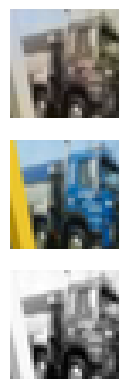

In [33]:
for inputs, targets in data_loader_lab:
  input_s = np.reshape(inputs, [20,1,32,32])
  target = targets
  outputs = model.forward(input_s.float())
  break

print(inputs.shape)
print(targets.shape)
print(outputs.shape)

input = np.reshape(inputs.detach().numpy()[0], (32,32,1))
output_s = outputs.detach().numpy()
target = target.detach().numpy()
image = np.swapaxes(np.swapaxes(output_s[0], 0, 1), 1, 2)
target = np.swapaxes(np.swapaxes(target[0], 0, 1), 1, 2)
real_image = np.concatenate((input, target), axis = 2 )
images_reconstructed = np.concatenate((input, image), axis = 2 )
images_reconstructed[:,:, 0] = images_reconstructed[:,:, 0]*100
images_reconstructed[:,:, 1:] = (images_reconstructed[:,:, 1:]*206.1)-107.86
real_image[:,:, 0] = real_image[:,:, 0]*100
real_image[:,:, 1:] = (real_image[:,:, 1:]*206.1)-107.86

print(image.shape)
print(target.shape)
print(images_reconstructed.shape)

print(np.max(images_reconstructed[:,:,1:]))
print(np.min(images_reconstructed[:,:,1:]))
print(np.max(images_reconstructed[:,:,0]))
print(np.min(images_reconstructed[:,:,0]))
images_reconstructed = images_reconstructed.astype(np.float32)
rgb_image = cv2.cvtColor(images_reconstructed, cv2.COLOR_Lab2RGB)
target_rgb_image = cv2.cvtColor(real_image.astype(np.float32), cv2.COLOR_Lab2RGB)
plt.figure()
plt.subplot(311)
plt.imshow(rgb_image)
# plt.subplots_adjust(left=0.4, right=0.5, top=0.5, bottom=0.4)
plt.axis('off')
#plt.show()
plt.subplot(312)
plt.imshow(target_rgb_image)

# plt.subplots_adjust(left=0.4, right=0.5, top=0.5, bottom=0.4)
plt.axis('off')
plt.subplot(313)
plt.imshow((input*255).astype(np.float32), cmap='gray')
# plt.subplots_adjust(left=0.4, right=0.5, top=0.5, bottom=0.4)

plt.axis('off')
plt.show()

In [14]:
def ConvertLabToRGB(input, output, target):
  #input = np.reshape(inputs.detach().numpy()[0], (32,32,1))
  #output_s = outputs.detach().numpy()
  #target = target.detach().numpy()
  image = np.swapaxes(np.swapaxes(output_s[0], 0, 1), 1, 2)
  target = np.swapaxes(np.swapaxes(target[0], 0, 1), 1, 2)
  real_image = np.concatenate((input, target), axis = 2 )
  images_reconstructed = np.concatenate((input, image), axis = 2 )
  images_reconstructed[:,:, 0] = images_reconstructed[:,:, 0]*100
  images_reconstructed[:,:, 1:] = (images_reconstructed[:,:, 1:]*206.1)-107.86
  real_image[:,:, 0] = real_image[:,:, 0]*100
  real_image[:,:, 1:] = (real_image[:,:, 1:]*206.1)-107.86

  images_reconstructed = images_reconstructed.astype(np.float32)
  rgb_image = cv2.cvtColor(images_reconstructed, cv2.COLOR_Lab2RGB)
  target_rgb_image = cv2.cvtColor(real_image.astype(np.float32), cv2.COLOR_Lab2RGB)
  grey_scale_image = images_reconstructed[:,:,0]*25.5
  return rgb_image, target_rgb_image, grey_scale_image